| Custom model | Logistic Regression model | DistilBert model |
|----------|----------|----------|
| 95.31% | 93.24%|96.23%|

by Walid Abdul Hakim 1900000480

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import transformers

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from tokenizers import BertWordPieceTokenizer
from keras.layers import Input, Dense, Embedding, GRU, LSTM
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout
from keras.initializers import Constant
from keras.models import Model
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased")
transformer_layer = transformers.TFAutoModel.from_pretrained('dbmdz/distilbert-base-turkish-cased')
model = TFAutoModelForSequenceClassification.from_pretrained("dbmdz/distilbert-base-turkish-cased")


Some layers from the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when initializing TFDistilBertModel: ['bert', 'nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertModel were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['distilbert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some layers from the model checkpoint at dbmdz/distilbert-base-turkish-cased were not used when 

(947030, 5)
  product name                                            comment  rating  \
0     Uno Flip  Merhaba, \nDaha önce yapmış olduğum yorumda ka...       5   
1     Uno Flip                            Gayet güzel hızlı geldi       5   
2     Uno Flip  Klasik ve diğer uno da gayet güzeldi bu da çok...       5   
3     Uno Flip  Kart ile alakalı bir iki defo sorunu vardı, yo...       5   
4     Uno Flip  Acayip eğlenceli orjinal UNO nun bir türü eğle...       5   

   likes  dislikes  
0      3         1  
1      4         4  
2      8         2  
3      0         0  
4      8         3  


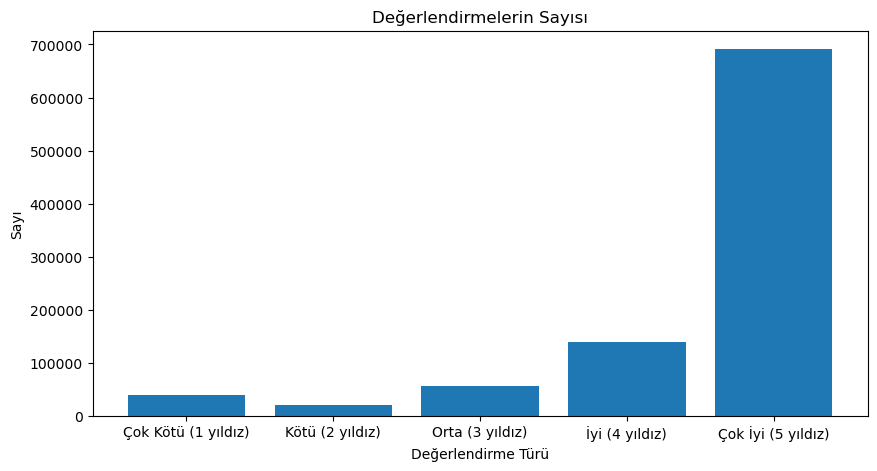

5    691280
4    138570
1     39369
2     21092
Name: rating, dtype: int64

In [6]:
df = pd.read_csv('Hepsiburada-product-comments.csv', encoding='utf-8-sig')
df.columns = ['product name', 'comment', 'rating', 'likes', 'dislikes']
print(df.shape)
print(df.head())

num_Verybad = np.count_nonzero(df['rating'] == 1)
num_bad = np.count_nonzero(df['rating'] == 2)
num_neu = np.count_nonzero(df['rating'] == 3)
num_good = np.count_nonzero(df['rating'] == 4)
num_Verygood = np.count_nonzero(df['rating'] == 5)

labels = ['Çok Kötü (1 yıldız)', 'Kötü (2 yıldız)', 'Orta (3 yıldız)', 'İyi (4 yıldız)', 'Çok İyi (5 yıldız)']
values = [num_Verybad, num_bad, num_neu, num_good, num_Verygood]

fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(labels, values)

plt.title('Değerlendirmelerin Sayısı')
plt.xlabel('Değerlendirme Türü')
plt.ylabel('Sayı')

plt.show()

df['rating'].value_counts()

df.drop(df[df["rating"] == 3].index, inplace=True) # Ortayı çıkarma daha doğru sonuçlar için
df['rating'].value_counts()

In [7]:
df['rating'].value_counts()

5    691280
4    138570
1     39369
2     21092
Name: rating, dtype: int64

<font size="20">PRE-PROCESSSING DATA</font>

In [8]:
#firtly, we drop all the rows with 3 value since the appear as nuetral values in this study.
df.drop(df[df["rating"] == 3].index, inplace = True)
#we classify the values over 3 as 1, below 3 as 0.
df["rating"] = df["rating"].replace(1, 0)
df["rating"] = df["rating"].replace(2, 0)
df["rating"] = df["rating"].replace(4, 1)
df["rating"] = df["rating"].replace(5, 1)
df["rating"].value_counts()

1    829850
0     60461
Name: rating, dtype: int64

In [9]:
df['rating'].value_counts()

1    829850
0     60461
Name: rating, dtype: int64

In [10]:
df.dropna(subset=['comment'], inplace=True)

In [11]:
#preprocess the data 
df["comment"] = df["comment"].apply(lambda x: x.lower())
df["comment"] = df["comment"].apply(lambda x: x.replace("\r", " "))
df["comment"] = df["comment"].apply(lambda x: x.replace("\n", " "))


<font size="20">distilbert MODEL</font>

In [12]:

save_path = 'distilbert_base_turkish_cased'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_turkish_cased/vocab.txt', lowercase=True)

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=23):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i + chunk_size]
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)
data = df["comment"].values.tolist()

In [13]:

vectorizer = CountVectorizer()
X = fast_encode(data, fast_tokenizer, maxlen=23)
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((619836, 23), (265644, 23), (619836,), (265644,))

In [14]:
embedding_size = 23
inp = Input(shape=(23,))
embedding_matrix = transformer_layer.weights[0].numpy()
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix),
trainable=False)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=x)

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1024, epochs=5, validation_data=(X_test, y_test))
model_preds = model.predict(X_test)

Epoch 1/5
606/606 [==============================] - 230s 373ms/step - loss: 0.1860 - accuracy: 0.9417 - val_loss: 0.1375 - val_accuracy: 0.9520
Epoch 2/5
606/606 [==============================] - 220s 363ms/step - loss: 0.1288 - accuracy: 0.9549 - val_loss: 0.1221 - val_accuracy: 0.9569
Epoch 3/5
606/606 [==============================] - 218s 360ms/step - loss: 0.1176 - accuracy: 0.9588 - val_loss: 0.1130 - val_accuracy: 0.9600
Epoch 4/5
606/606 [==============================] - 218s 360ms/step - loss: 0.1111 - accuracy: 0.9610 - val_loss: 0.1098 - val_accuracy: 0.9613
Epoch 5/5
8302/8302 [==============================] - 99s 12ms/step


In [16]:
model_preds = (model_preds > 0.5).astype(int)
conf_met = confusion_matrix(y_test, model_preds)

print("Confusion metrics")
print(conf_met)

Confusion metrics
[[ 10046   7904]
 [  2219 245475]]


In [17]:
print('classification report')
print(classification_report(y_test, model_preds))

classification report
              precision    recall  f1-score   support

           0       0.82      0.56      0.66     17950
           1       0.97      0.99      0.98    247694

    accuracy                           0.96    265644
   macro avg       0.89      0.78      0.82    265644
weighted avg       0.96      0.96      0.96    265644



In [18]:


model_accuracy = accuracy_score(y_test, tf.squeeze(tf.round(model_preds))) * 100
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test, tf.squeeze(tf.round(model_preds)),
average="weighted")
model_results = {"accuracy": model_accuracy, "precision": model_precision * 100, "recall": model_recall * 100,
"f1": model_f1 * 100}

model_results


{'accuracy': 96.18926081522639,
 'precision': 95.86883284516043,
 'recall': 96.18926081522639,
 'f1': 95.85238017605079}

<font size="20">LOGISTIC REGRESSION</font>

In [19]:
# Train a logistic regression model on the training data
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-score: {:.2f}%".format(f1 * 100))

Accuracy: 93.24%
Precision: 93.24%
Recall: 100.00%
F1-score: 96.50%


<font size="20">CUSTOM MODEL</font>

In [26]:
from tensorflow.python.keras.models import Sequential

embedding_size = 50
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], embeddings_initializer=Constant(embedding_matrix)))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dense(units = 32))
model.add(Dense(units = 16))
model.add(Dense(1, activation = "sigmoid"))

X_train_pad = np.array(X_train)
y_train = np.array(y_train)

model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
model.fit(X_train_pad, y_train, epochs = 5, batch_size = 1024)

Epoch 1/5
606/606 [==============================] - 272s 446ms/step - loss: 0.1663 - accuracy: 0.9465
Epoch 2/5
606/606 [==============================] - 271s 447ms/step - loss: 0.1351 - accuracy: 0.9548
Epoch 3/5
606/606 [==============================] - 267s 441ms/step - loss: 0.1260 - accuracy: 0.9578
Epoch 4/5
606/606 [==============================] - 265s 438ms/step - loss: 0.1177 - accuracy: 0.9606
Epoch 5/5
606/606 [==============================] - 267s 440ms/step - loss: 0.1098 - accuracy: 0.9633


In [33]:
X_test_pad = np.array(X_test)

In [35]:
X_test_pad = np.array(X_test_pad)
y_test = np.array(y_test)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)


# Print the scores
print('Test Accuracy:', accuracy)

Test Accuracy: 0.9531556367874146
